In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv('~/Capstone/data/airbnb-listings_cleaned.csv', low_memory=False)

In [3]:
df.head(5)

,Last Scraped,Experiences Offered,Host Name,Host Since,Host Location,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Host Total Listings Count,...,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Calculated host listings count,Reviews per Month,Features
0,2017-04-02,none,Lithal,2014-09-01,"Amsterdam, North Holland, Netherlands",within a day,50.0,Oud-West,1.0,1.0,...,9.0,8.0,9.0,10.0,10.0,9.0,strict,1.0,1.52,"Host Has Profile Pic,Host Identity Verified,Is..."
1,2017-04-02,none,Hein,2014-02-05,"Amsterdam, North Holland, The Netherlands",within a few hours,100.0,Oud-West,1.0,1.0,...,9.0,9.0,9.0,10.0,10.0,9.0,strict,1.0,0.81,"Host Is Superhost,Host Has Profile Pic,Host Id..."
2,2017-04-02,none,Matthieu,2014-11-12,"Amsterdam, North Holland, The Netherlands",Unknown,100.0,Oud-West,1.0,1.0,...,10.0,10.0,10.0,10.0,10.0,10.0,flexible,1.0,0.05,"Host Has Profile Pic,Host Identity Verified,Is..."
3,2017-04-02,none,Bas,2013-10-05,"Amsterdam, North Holland, The Netherlands",within a day,100.0,Oud-West,1.0,1.0,...,10.0,9.0,10.0,9.0,9.0,9.0,flexible,1.0,0.62,"Host Has Profile Pic,Host Identity Verified,Is..."
4,2017-04-02,none,Pablo,2016-08-10,"Amsterdam, North Holland, Netherlands",within a day,100.0,Unknown,1.0,1.0,...,8.0,8.0,8.0,8.0,9.0,9.0,moderate,1.0,2.04,Host Has Profile Pic


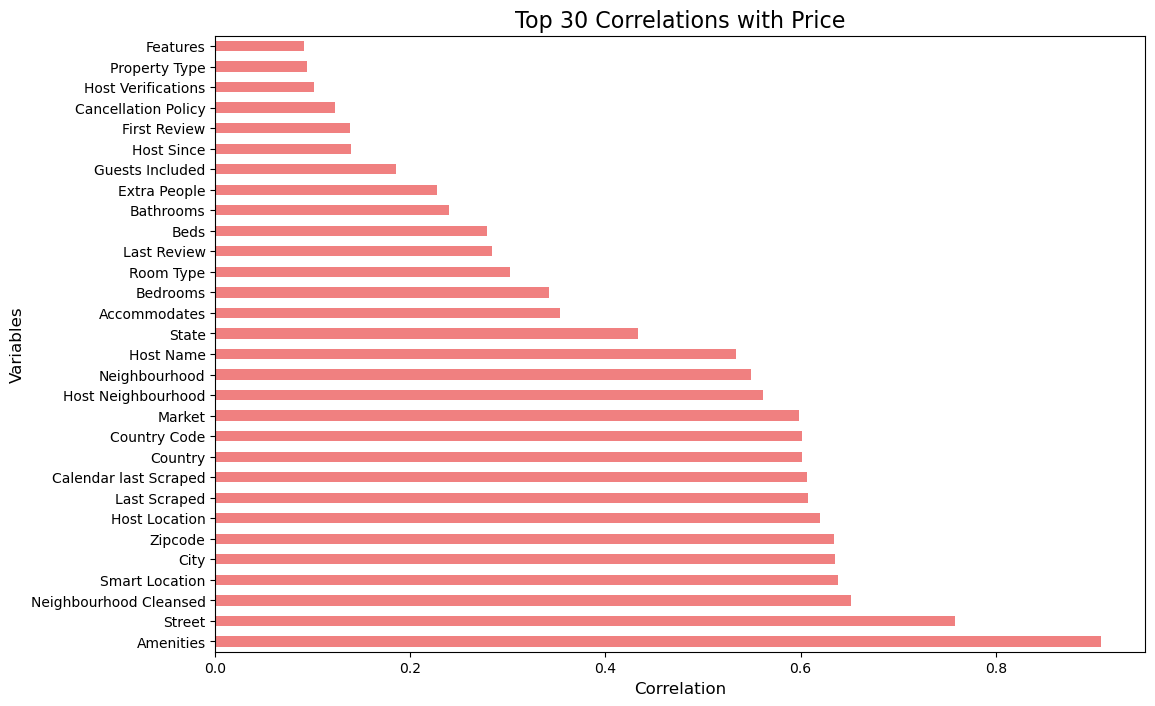

In [4]:
# Encode categorical features with mean price
categorical_cols = df.select_dtypes(include=['object']).columns
df_le = df.copy()
for col in categorical_cols:
    le = LabelEncoder()
    df_le[col] = df_le.groupby(col)['Price'].transform('mean')

# Convert datetime columns to integer format (seconds since epoch)
datetime_column = df.select_dtypes(include=['datetime64']).columns
for col in datetime_column:
    df_le[col] = df_le[col].astype('int64') // 10**9

# Compute the correlation matrix
corr_matrix = df_le.corr()

# Select the correlations of other variables with the target variable "Price"
price_corr = corr_matrix['Price'].abs().sort_values(ascending=False)

# Select top 30 correlations excluding the target variable itself
top_30_corr = price_corr[1:31]

# Plot the correlation bar chart
plt.figure(figsize=(12, 8))
top_30_corr.plot(kind='barh', color='lightcoral')
plt.title('Top 30 Correlations with Price', fontsize=16)
plt.xlabel('Correlation', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.show()

#### Feature Selection

In [5]:
sf = ['Amenities', 'Street', 'Neighbourhood Cleansed', 'Host Name', 'Bedrooms', 'Accommodates', 'Room Type', 'Bathrooms']
X = df_le[sf]
y = df_le['Price']

#### First Split

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

#### Second Split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1111, random_state=42)

In [8]:
# Convert test set to DataFrames and export
X_test_df = pd.DataFrame(X_test, columns=X.columns if hasattr(X, 'columns') else None)
# For y_test (target)
y_test_df = pd.DataFrame(y_test, columns=['target'] if y_test.ndim == 1 else None)
# Combine features and target for test set
test_df = pd.concat([X_test_df, y_test_df], axis=1)
# Export test set
test_df.to_csv('~/Capstone/data/test_set.csv', index=False)

# Convert validation set to DataFrames and export
X_val_df = pd.DataFrame(X_val, columns=X.columns if hasattr(X, 'columns') else None)
y_val_df = pd.DataFrame(y_val, columns=['target'] if y_val.ndim == 1 else None)
val_df = pd.concat([X_val_df, y_val_df], axis=1)
val_df.to_csv('~/Capstone/data/validation_set.csv', index=False)

# Convert training set to DataFrames and export
X_train_df = pd.DataFrame(X_train, columns=X.columns if hasattr(X, 'columns') else None)
y_train_df = pd.DataFrame(y_train, columns=['target'] if y_train.ndim == 1 else None)
train_df = pd.concat([X_train_df, y_train_df], axis=1)
train_df.to_csv('~/Capstone/data/training_set.csv', index=False)

#### Linear Regression Model Application and Evaluation

In [9]:
lm_model = LinearRegression()

#### K-Fold Cross Validation

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [11]:
print("Model 1 - Linear Regression")
cv_r = []
for fold, (train_i,val_i) in enumerate(kf.split(X_train),1):
    X_train_f, X_val_f = X_train.iloc[train_i], X_train.iloc[val_i]
    y_train_f, y_val_f = y_train.iloc[train_i], y_train.iloc[val_i]

    s = StandardScaler()
    X_train_s = s.fit_transform(X_train_f)
    X_val_s = s.transform(X_val_f)

    lm_model.fit(X_train_s,y_train_f)
    y_pred = lm_model.predict(X_val_s)

    mse = mean_squared_error(y_val_f, y_pred)
    mae = mean_absolute_error(y_val_f, y_pred)
    r2 = r2_score(y_val_f, y_pred)

    cv_r.append({'Fold': fold, 'MSE': mse, 'MAE': mae, 'R2': r2})
    
    print(f"Fold {fold} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

Model 1 - Linear Regression
Fold 1 - MSE: 2978.3434, MAE: 27.2430, R2: 0.8657
Fold 2 - MSE: 2896.5145, MAE: 27.1349, R2: 0.8689
Fold 3 - MSE: 2952.9891, MAE: 27.3699, R2: 0.8659
Fold 4 - MSE: 2959.9590, MAE: 27.3386, R2: 0.8654
Fold 5 - MSE: 3038.9513, MAE: 27.3794, R2: 0.8649


In [12]:
avg_mse = np.mean([fold['MSE'] for fold in cv_r])
avg_mae = np.mean([fold['MAE'] for fold in cv_r])
avg_r2 = np.mean([fold['R2'] for fold in cv_r])
print(f"\nAverage CV - MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}, R2: {avg_r2:.4f}")


Average CV - MSE: 2965.3514, MAE: 27.2932, R2: 0.8662


#### Train model on whole train set and evaluate on validation set

In [13]:
s_2 = StandardScaler()
X_train_s = s_2.fit_transform(X_train)
X_val_s = s_2.transform(X_val)

In [14]:
lm_model.fit(X_train_s,y_train)
y_pred_val = lm_model.predict(X_val_s)

In [15]:
mse = mean_squared_error(y_val, y_pred_val)
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
print(f"\nValidation Results - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


Validation Results - MSE: 3033.0690, MAE: 27.3368, R2: 0.8585


#### Last Evaluation on test set

In [16]:
X_test_s = s_2.transform(X_test)
y_pred_test = lm_model.predict(X_test_s)

In [17]:
mse_t = mean_squared_error(y_test, y_pred_test)
mae_t = mean_absolute_error(y_test, y_pred_test)
r2_t = r2_score(y_test, y_pred_test)
print(f"\nTest Results - MSE: {mse_t:.4f}, MAE: {mae_t:.4f}, R2: {r2_t:.4f}")


Test Results - MSE: 2977.0707, MAE: 27.2840, R2: 0.8653


#### Random Forest Regression Model Application and Evaluation

In [18]:
rf_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)

#### K-Fold Cross Validation

In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [20]:
print("Model 2 - Random Forest Regression")
cv_r = []
for fold, (train_i,val_i) in enumerate(kf.split(X_train),1):
    X_train_f, X_val_f = X_train.iloc[train_i], X_train.iloc[val_i]
    y_train_f, y_val_f = y_train.iloc[train_i], y_train.iloc[val_i]

    s = StandardScaler()
    X_train_s = s.fit_transform(X_train_f)
    X_val_s = s.transform(X_val_f)

    rf_model.fit(X_train_s,y_train_f)
    y_pred = rf_model.predict(X_val_s)

    mse = mean_squared_error(y_val_f, y_pred)
    mae = mean_absolute_error(y_val_f, y_pred)
    r2 = r2_score(y_val_f, y_pred)

    cv_r.append({'Fold': fold, 'MSE': mse, 'MAE': mae, 'R2': r2})
    
    print(f"Fold {fold} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

Model 2 - Random Forest Regression
Fold 1 - MSE: 1881.2501, MAE: 15.3614, R2: 0.9152
Fold 2 - MSE: 1837.6162, MAE: 15.4155, R2: 0.9168
Fold 3 - MSE: 1865.8119, MAE: 15.4441, R2: 0.9153
Fold 4 - MSE: 1887.7830, MAE: 15.5338, R2: 0.9142
Fold 5 - MSE: 1973.1052, MAE: 15.4727, R2: 0.9123


In [21]:
avg_mse = np.mean([fold['MSE'] for fold in cv_r])
avg_mae = np.mean([fold['MAE'] for fold in cv_r])
avg_r2 = np.mean([fold['R2'] for fold in cv_r])
print(f"\nAverage CV - MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}, R2: {avg_r2:.4f}")


Average CV - MSE: 1889.1133, MAE: 15.4455, R2: 0.9147


#### Train model on whole train set and evaluate on validation set

In [22]:
s_2 = StandardScaler()
X_train_s = s_2.fit_transform(X_train)
X_val_s = s_2.transform(X_val)

In [23]:
rf_model.fit(X_train_s,y_train)
y_pred_val = rf_model.predict(X_val_s)

In [24]:
mse = mean_squared_error(y_val, y_pred_val)
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
print(f"\nValidation Results - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


Validation Results - MSE: 1840.5930, MAE: 15.1676, R2: 0.9141


#### Last Evaluation on test set

In [25]:
X_test_s = s_2.transform(X_test)
y_pred_test = rf_model.predict(X_test_s)

In [26]:
mse_t = mean_squared_error(y_test, y_pred_test)
mae_t = mean_absolute_error(y_test, y_pred_test)
r2_t = r2_score(y_test, y_pred_test)
print(f"\nTest Results - MSE: {mse_t:.4f}, MAE: {mae_t:.4f}, R2: {r2_t:.4f}")


Test Results - MSE: 1837.2659, MAE: 15.0533, R2: 0.9168


#### Gradient Boosting Regression Model Application and Evaluation

In [27]:
gb_model = GradientBoostingRegressor()

#### K-Fold Cross Validation

In [28]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [29]:
print("Model 3 - Gradient Boosting Regression")
cv_r = []
for fold, (train_i,val_i) in enumerate(kf.split(X_train),1):
    X_train_f, X_val_f = X_train.iloc[train_i], X_train.iloc[val_i]
    y_train_f, y_val_f = y_train.iloc[train_i], y_train.iloc[val_i]

    s = StandardScaler()
    X_train_s = s.fit_transform(X_train_f)
    X_val_s = s.transform(X_val_f)

    gb_model.fit(X_train_s,y_train_f)
    y_pred = gb_model.predict(X_val_s)

    mse = mean_squared_error(y_val_f, y_pred)
    mae = mean_absolute_error(y_val_f, y_pred)
    r2 = r2_score(y_val_f, y_pred)

    cv_r.append({'Fold': fold, 'MSE': mse, 'MAE': mae, 'R2': r2})
    
    print(f"Fold {fold} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

Model 3 - Gradient Boosting Regression
Fold 1 - MSE: 2147.7309, MAE: 20.9766, R2: 0.9032
Fold 2 - MSE: 2086.8547, MAE: 21.0400, R2: 0.9055
Fold 3 - MSE: 2119.3647, MAE: 21.1550, R2: 0.9038
Fold 4 - MSE: 2134.5780, MAE: 20.9049, R2: 0.9029
Fold 5 - MSE: 2216.8537, MAE: 21.2301, R2: 0.9014


In [30]:
avg_mse = np.mean([fold['MSE'] for fold in cv_r])
avg_mae = np.mean([fold['MAE'] for fold in cv_r])
avg_r2 = np.mean([fold['R2'] for fold in cv_r])
print(f"\nAverage CV - MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}, R2: {avg_r2:.4f}")


Average CV - MSE: 2141.0764, MAE: 21.0613, R2: 0.9034


#### Train model on whole train set and evaluate on validation set

In [31]:
s_2 = StandardScaler()
X_train_s = s_2.fit_transform(X_train)
X_val_s = s_2.transform(X_val)

In [32]:
gb_model.fit(X_train_s,y_train)
y_pred_val = gb_model.predict(X_val_s)

In [33]:
mse = mean_squared_error(y_val, y_pred_val)
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
print(f"\nValidation Results - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


Validation Results - MSE: 2199.6697, MAE: 21.1132, R2: 0.8974


#### Last Evaluation on test set

In [34]:
X_test_s = s_2.transform(X_test)
y_pred_test = gb_model.predict(X_test_s)

In [35]:
mse_t = mean_squared_error(y_test, y_pred_test)
mae_t = mean_absolute_error(y_test, y_pred_test)
r2_t = r2_score(y_test, y_pred_test)
print(f"\nTest Results - MSE: {mse_t:.4f}, MAE: {mae_t:.4f}, R2: {r2_t:.4f}")


Test Results - MSE: 2168.9048, MAE: 20.9695, R2: 0.9018


#### K Nearest Neighbors Regression Model Application and Evaluation

In [36]:
knn_model = KNeighborsRegressor()

#### K-Fold Cross Validation

In [37]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [38]:
print("Model 4 - K-Nearest Neighbors Regression")
cv_r = []
for fold, (train_i,val_i) in enumerate(kf.split(X_train),1):
    X_train_f, X_val_f = X_train.iloc[train_i], X_train.iloc[val_i]
    y_train_f, y_val_f = y_train.iloc[train_i], y_train.iloc[val_i]

    s = StandardScaler()
    X_train_s = s.fit_transform(X_train_f)
    X_val_s = s.transform(X_val_f)

    knn_model.fit(X_train_s,y_train_f)
    y_pred = knn_model.predict(X_val_s)

    mse = mean_squared_error(y_val_f, y_pred)
    mae = mean_absolute_error(y_val_f, y_pred)
    r2 = r2_score(y_val_f, y_pred)

    cv_r.append({'Fold': fold, 'MSE': mse, 'MAE': mae, 'R2': r2})
    
    print(f"Fold {fold} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

Model 4 - K-Nearest Neighbors Regression
Fold 1 - MSE: 2303.0381, MAE: 20.8901, R2: 0.8962
Fold 2 - MSE: 2260.1015, MAE: 20.8061, R2: 0.8977
Fold 3 - MSE: 2308.7543, MAE: 20.9020, R2: 0.8952
Fold 4 - MSE: 2318.1488, MAE: 21.0389, R2: 0.8946
Fold 5 - MSE: 2365.2770, MAE: 20.9024, R2: 0.8948


In [39]:
avg_mse = np.mean([fold['MSE'] for fold in cv_r])
avg_mae = np.mean([fold['MAE'] for fold in cv_r])
avg_r2 = np.mean([fold['R2'] for fold in cv_r])
print(f"\nAverage CV - MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}, R2: {avg_r2:.4f}")


Average CV - MSE: 2311.0639, MAE: 20.9079, R2: 0.8957


#### Train model on whole train set and evaluate on validation set

In [40]:
s_2 = StandardScaler()
X_train_s = s_2.fit_transform(X_train)
X_val_s = s_2.transform(X_val)

In [41]:
knn_model.fit(X_train_s,y_train)
y_pred_val = knn_model.predict(X_val_s)

In [42]:
mse = mean_squared_error(y_val, y_pred_val)
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
print(f"\nValidation Results - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


Validation Results - MSE: 2348.9617, MAE: 20.7650, R2: 0.8904


#### Last Evaluation on test set

In [43]:
X_test_s = s_2.transform(X_test)
y_pred_test = knn_model.predict(X_test_s)

In [44]:
mse_t = mean_squared_error(y_test, y_pred_test)
mae_t = mean_absolute_error(y_test, y_pred_test)
r2_t = r2_score(y_test, y_pred_test)
print(f"\nTest Results - MSE: {mse_t:.4f}, MAE: {mae_t:.4f}, R2: {r2_t:.4f}")


Test Results - MSE: 2361.1094, MAE: 20.5758, R2: 0.8931
